In [41]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.hardwaremanager import HardwareManager
from hardware.pulser.pulser import OutputState, TriggerRearm, TriggerStart
from hardware import config as hcf

import numpy as np
import matplotlib.pyplot as plt

In [42]:
from logmodule import setup_logging
setup_logging()
import logging
logger = logging.getLogger(__name__)

In [43]:
hw = HardwareManager()
hw.add_default_hardware()

2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware VDISource is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware WindfreakSynth is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware MWPowerMeter is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware LaserControl is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware PulseGenerator is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware FIFO_DataAcquisition is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware CameraController is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware WhiteLight is already loaded.
2025-07-24 21:35:17 INFO hardwaremanager MainThread: Hardware initialization process has finished.


In [44]:
def seqtime(seq_tb):
    """"calculate the sequence total time"""
    return np.sum([pulse[-1] for pulse in seq_tb])

def slice_average(data: np.ndarray, signal_range: tuple[int, int]) -> np.ndarray:
    """
    Computes the mean over a specified signal range for each row.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_range (tuple[int, int]): (start, end) index range (exclusive end).

    Returns:
        np.ndarray: 1D array of row-wise means over the signal range.
    """
    start, end = signal_range
    return np.mean(data[:, start:end], axis=1)


def slice_average_offset(
    data: np.ndarray, signal_range: tuple[int, int], background_range: tuple[int, int]
) -> np.ndarray:
    """
    Computes the mean over a signal range minus the mean over a background range.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_range (tuple[int, int]): (start, end) index range for the signal.
        background_range (tuple[int, int]): (start, end) index range for the background.

    Returns:
        np.ndarray: 1D array of background-subtracted signal means.
    """
    signal = slice_average(data, signal_range)
    background = slice_average(data, background_range)
    return signal - background


def weighted_average(data: np.ndarray, weight_fn: callable) -> np.ndarray:
    """
    Computes the weighted average over all columns using a custom weight function.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        weight_fn (callable): Function that maps indices (np.arange) to weights.

    Returns:
        np.ndarray: 1D array of weighted averages per row.
    """
    indices = np.arange(data.shape[1])
    weights = weight_fn(indices)
    weights = weights / np.sum(weights)
    return np.average(data, axis=1, weights=weights)


def weighted_average_offset(
    data: np.ndarray, signal_weight_fn: callable, background_range: tuple[int, int]
) -> np.ndarray:
    """
    Computes the weighted average of a signal region minus the mean over a background slice.

    Parameters:
        data (np.ndarray): 2D array (rows = segments, columns = samples).
        signal_weight_fn (callable): Weight function over all columns for the signal.
        background_range (tuple[int, int]): (start, end) index range for background.

    Returns:
        np.ndarray: 1D array of background-subtracted weighted averages.
    """
    signal = weighted_average(data, signal_weight_fn)
    background = slice_average(data, background_range)
    return signal - background



In [45]:
T_PREUNBLK_MIN = 1000  #  1us mini pre-unblanking time
T_UNBLK_MAX = 300e6  # max unblanking time for the amplifier is 300ms
T_PREUNBLK = T_PREUNBLK_MIN + 500  #  we use 1.5us pre-unblanking time

In [46]:
hw.whitelight.set_voltage(0.0)

In [47]:
stateset = dict(
    priority=0,
    state="",
    tokeep=False,
    time_run=0,
    time_stop=120,
    idx_run=0,
    num_run=9999999,
    rate_refresh=10)

paraset = dict(
            rate_refresh=10.0,
            # --------------------
            laser_current=60.0,  # percentage
            mw_freq=392.8488,  # GHz
            mw_powervolt=5.0,  # voltage 0.0 to 5.0
            mw_phasevolt=0.0,  # voltage 0.0 to 5.0
            rf_set=False,  # set the RF manually before running the measurement
            # rf_a_amp=0.5,  # amplitude for rf A
            # rf_b_amp=0.5,  # amplitude for rf B
            # rf_a_freq=600.8,  # MHz
            # rf_b_freq=600.8,  # MHz
            # rf_a_phase=0.0,  # phase for rf A
            # rf_b_phase=0.0,  # phase for rf B
            amp_input=1000,  # input amplitude for digitizer

            # -------------------
            n_track=1000,  # number of tracks
            # -------------------
            t_prep_laser=250.0,  # laser time in the preparation phase in a track
            t_prep_isc=250.0,  # wait time for ISC in the preparation phase in a track
            n_prep_lpul=100,  # number of laser pulses in the preparation phase in a track
            # -------------------
            t_prob_init_wait=300.0,
            t_prob_mw_a_pio2=28.0,
            t_prob_phacc=0.0,
            t_prob_read_wait=300.0,
            t_prob_laser=600.0,
            n_dbloc_fwd=8,  # number of a probe
            n_dbloc_bwd=8,  # number of b probe
            # -------------------
            t_rf_pio2=16666,
            t_prlo=90000,  # pre-lock time
            t_lock_fwd=17000,
            t_lock_bwd=17000,
            # -------------------
            emulate=True,
        )

dataset = dict(
            num_repeat=0,
            tau_AB=np.zeros(2, dtype=np.float64),  # time of free evolution
            tau_BA=np.zeros(2, dtype=np.float64),  # time of free evolution
            sig_AB=np.zeros(2, dtype=np.float64),  # signal for AB
            sig_AB_bg=np.zeros(2, dtype=np.float64),  # background signal for AB
            sig_BA=np.zeros(2, dtype=np.float64),  # signal for BA
            sig_BA_bg=np.zeros(2, dtype=np.float64),  # background signal for BA
        )

tokeep = False

In [48]:
def _parameter_check():
    t_prob_init_wait = paraset["t_prob_init_wait"]
    t_prob_mw_a_pio2 = paraset["t_prob_mw_a_pio2"]
    t_prob_phacc = paraset["t_prob_phacc"]
    t_prob_read_wait = paraset["t_prob_read_wait"]
    t_prob_laser = paraset["t_prob_laser"]
    n_dbloc_fwd = paraset["n_dbloc_fwd"]
    n_dbloc_bwd = paraset["n_dbloc_bwd"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    t_prlo = paraset["t_prlo"]
    n_track = paraset["n_track"]
    assert n_track % 2 == 0, (
        "Number of tracks must be even for the protocol to work properly."
    )
    t_prep_laser = paraset["t_prep_laser"]
    t_prep_isc = paraset["t_prep_isc"]
    n_prep_lpul = paraset["n_prep_lpul"]

    t_lock = t_lock_fwd + t_lock_bwd  # total time for a nuclerar spin lock
    t_fevo = t_prlo + t_lock + t_prlo
    assert T_PREUNBLK * 2 + t_lock < T_UNBLK_MAX
    assert (
        t_fevo >= 5 * t_lock + T_PREUNBLK * 2
    )  # the duty cycle for RF must be <20%

    t_dbloc = (
        t_prob_init_wait
        + t_prob_mw_a_pio2
        + t_prob_phacc
        + t_prob_mw_a_pio2
        + t_prob_read_wait
        + t_prob_laser
    )  # the detection block depends on the sensing sequence on the sensor
    assert t_lock_fwd >= n_dbloc_fwd * t_dbloc, (
        "Lock time (pos) is not enough for the sequence."
    )
    assert t_lock_bwd >= n_dbloc_bwd * t_dbloc, (
        "Lock time (neg) is not enough for the sequence."
    )
    n_dbloc = n_dbloc_fwd + n_dbloc_bwd
    t_prob_dbloc = t_dbloc * n_dbloc
    t_prob_empt_fwd = t_lock_fwd - n_dbloc_fwd * t_dbloc
    t_prob_empt_bwd = t_lock_bwd - n_dbloc_bwd * t_dbloc
    t_prob = t_prob_empt_fwd + t_prob_dbloc +t_prob_empt_bwd
    t_prep = (t_prlo + t_lock) - t_prob
    t_prep_init = (t_prep_laser + t_prep_isc) * n_prep_lpul
    t_prep_empt = t_prep - t_prep_init
    assert t_prep_empt >= 0, "Preparation time is not enough for the sequence."
    
    assert (t_prlo + t_lock) == (t_prep + t_prob)
    paraset["t_lock"] = t_lock  # store it in the parameter set
    paraset["t_fevo"] = t_fevo  # store it in the parameter set
    paraset["t_prob"] = t_prob  # store it in the parameter set
    paraset["t_prob_dbloc"] = t_prob_dbloc  # store it in the parameter set
    paraset["t_prob_empt_fwd"] = t_prob_empt_fwd  # store it in the parameter set
    paraset["t_prob_empt_bwd"] = t_prob_empt_bwd  # store it in the parameter set
    paraset["t_dbloc"] = t_dbloc  # store it in the parameter set
    paraset["t_prep"] = t_prep  # store it in the parameter set
    paraset["t_prep_empt"] = t_prep_empt  # store it in the parameter set
    paraset["t_prep_init"] = t_prep_init  # store it in the parameter set
    paraset["n_dbloc"] = n_dbloc  # store it in the parameter set
    # n_seg = n_dbloc * 4  # number of readout segments per track
    # paraset["n_seg"] = n_seg  # store it in the parameter set

def _sequence_sensor():
    t_prob_init_wait = paraset["t_prob_init_wait"]
    t_prob_mw_a_pio2 = paraset["t_prob_mw_a_pio2"]
    t_prob_phacc = paraset["t_prob_phacc"]
    t_prob_read_wait = paraset["t_prob_read_wait"]
    t_prob_empt_fwd = paraset["t_prob_empt_fwd"]
    t_prob_empt_bwd = paraset["t_prob_empt_bwd"]
    t_prob_laser = paraset["t_prob_laser"]
    n_dbloc_fwd = paraset["n_dbloc_fwd"]
    n_dbloc_bwd = paraset["n_dbloc_bwd"]
    # t_lock_fwd = paraset["t_lock_fwd"]
    # t_lock_bwd = paraset["t_lock_bwd"]
    t_prep_laser = paraset["t_prep_laser"]
    t_prep_isc = paraset["t_prep_isc"]
    n_prep_lpul = paraset["n_prep_lpul"]
    n_track = paraset["n_track"]
    t_prep_empt = paraset["t_prep_empt"]
    # t_dbloc = paraset["t_dbloc"]

    t_rf_pio2 = paraset["t_rf_pio2"]
    seq_pretrack = [([], t_rf_pio2)]
    seq_prep = [([], t_prep_empt)] + [
        (["laser"], t_prep_laser),
        ([], t_prep_isc),
    ] * n_prep_lpul

    seq_prob = (
        [([], t_prob_empt_fwd)]
        + [
            ([], t_prob_init_wait),
            # (["mwA"], t_prob_mw_a_pio2),
            ([], t_prob_mw_a_pio2),
            ([], t_prob_phacc),
            # (["mwA"], t_prob_mw_a_pio2),
            ([], t_prob_mw_a_pio2),
            ([], t_prob_read_wait),
            (["laser", "sdtrig"], t_prob_laser),
        ]
        * (n_dbloc_fwd + n_dbloc_bwd)
        + [([], t_prob_empt_bwd)]
    )

    seq = seq_prep + seq_prob
    # return seq * n_track
    return seq_pretrack + seq * 4 * n_track, None

def _sequence_target():
    t_rf_pio2 = paraset["t_rf_pio2"]
    t_prlo = paraset["t_prlo"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    n_track = paraset["n_track"]
    # prime the amplifier by putting the BLK in advance
    # seq_prlo = [([], t_prlo)]
    seq_prlo_blk_fall = [(["BLK"], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), (["BLK"], T_PREUNBLK)]
    seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_lockAB = [(["rfA", "BLK"], t_lock_fwd)] + [(["rfB", "BLK"], t_lock_bwd)]
    seq_lockBA = [(["rfB", "BLK"], t_lock_fwd)] + [(["rfA", "BLK"], t_lock_bwd)]
    seq = (
        seq_prlo_blk_fall
        + seq_nolock
        + seq_prlo_blk_rise
        + seq_lockAB
        + seq_prlo_blk_fall
        + seq_nolock
        + seq_prlo_blk_rise
        + seq_lockBA
    )
    seq_pretrack = [(["rfB"], t_rf_pio2)]
    return seq_pretrack + seq * n_track, None

def _sequence_target_emulation():
    t_rf_pio2 = paraset["t_rf_pio2"]
    t_prlo = paraset["t_prlo"]
    t_lock_fwd = paraset["t_lock_fwd"]
    t_lock_bwd = paraset["t_lock_bwd"]
    t_fevo = paraset["t_fevo"]
    n_track = paraset["n_track"]

    # prime the amplifier by putting the BLK in advance
    # seq_prlo = [([], t_prlo)]
    # seq_prlo_blk_fall = [([], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    # seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), ([], T_PREUNBLK)]
    # seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    # seq_lockAB = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    # seq_lockBA = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_prlo_blk_fall = [(["BLK"], T_PREUNBLK), ([], t_prlo - T_PREUNBLK)]
    seq_prlo_blk_rise = [([], t_prlo - T_PREUNBLK), (["BLK"], T_PREUNBLK)]
    seq_nolock = [([], t_lock_fwd)] + [([], t_lock_bwd)]
    seq_lockAB = [(["rfA", "BLK"], t_lock_fwd)] + [(["rfB", "BLK"], t_lock_bwd)]
    seq_lockBA = [(["rfB", "BLK"], t_lock_fwd)] + [(["rfA", "BLK"], t_lock_bwd)]
    seq = (
        seq_prlo_blk_fall
        + seq_nolock
        + seq_prlo_blk_rise
        + seq_lockAB
        + seq_prlo_blk_fall
        + seq_nolock
        + seq_prlo_blk_rise
        + seq_lockBA
    )
    seq_pretrack = [([], t_rf_pio2)]
    seq_digi = seq_pretrack + seq * n_track
    # some analog seq --------------------------
    Hz = 1e-9
    amp = 1.0
    omega = 2 * np.pi * 560.425266 * Hz
    wmf_fevo = [(t_fevo, 0)]
    wfm_anlg = [(t_rf_pio2, 0)]
    for ii_track in range(n_track):
        t_i_AB = ii_track * t_fevo * 2 + 1 * t_fevo
        t_i_BA = ii_track * t_fevo * 2 + 2 * t_fevo
        # amp_mod_AB = amp * np.cos(omega * t_i_AB)
        amp_mod_AB = 0
        amp_mod_BA = amp * np.cos(omega * t_i_BA)
        # mz analog pattern in a spin lock
        rabi_nuclear = 1.0 / t_rf_pio2 / 4.0
        ac_samplerate = rabi_nuclear * 20.0  # 20 pt per period
        dt = int(1 / ac_samplerate)
        # n_dt = int(t_rf_pio2 * ac_samplerate)
        # dt = int(t_rf_pio2 / n_dt)
        ttt_fwd = np.arange(0.0, t_lock_fwd//dt*dt, dt)
        ttt_bwd = np.arange(0.0, t_lock_bwd//dt*dt, dt)
        ttt_fwd_end_compen = t_lock_fwd-len(ttt_fwd)*dt
        ttt_bwd_end_compen = t_lock_bwd-len(ttt_bwd)*dt
        # print(f" t pi/2 rf : {t_rf_pio2}")
        # print(f"dt sampling time: {dt}")
        # print(f" dt time total : {len(ttt_fwd)*dt}")
        # print(f"forward ttt time end: {ttt_fwd[-1]}")
        # print(f" forward lock time : {t_lock_fwd}")
        # ttt_fwd = np.linspace(0.0, t_rf_pio2, n_dt, endpoint=True)
        # ttt_bwd = np.linspace(0.0, t_rf_pio2, n_dt, endpoint=True)

        mz_wave_fwd = np.sin(2 * np.pi * rabi_nuclear * ttt_fwd)
        mz_wave_fwd_end = np.sin(2 * np.pi * rabi_nuclear * len(ttt_fwd)*dt)
        mz_wave_bwd = np.sin(2 * np.pi * rabi_nuclear * (-ttt_bwd + t_lock_fwd))
        mz_wave_bwd_end = np.sin(2 * np.pi * rabi_nuclear * (-len(ttt_bwd)*dt + t_lock_fwd))
        
        wfm_lock_AB = [
            (dt, amp_mod_AB * val) for val in mz_wave_fwd
        ] + [(ttt_fwd_end_compen, amp_mod_AB * mz_wave_fwd_end)]+[
            (dt, amp_mod_AB * val) for val in mz_wave_bwd
        ] + [(ttt_bwd_end_compen, amp_mod_AB * mz_wave_bwd_end)]
        
        wfm_lock_BA = [
            (dt, amp_mod_BA * val) for val in mz_wave_fwd
        ] + [(ttt_fwd_end_compen, amp_mod_BA * mz_wave_fwd_end)]+[
            (dt, amp_mod_BA * val) for val in mz_wave_bwd
        ] + [(ttt_bwd_end_compen, amp_mod_BA * mz_wave_bwd_end)]
        wfm_anlg += wmf_fevo + wfm_lock_AB + wmf_fevo + wfm_lock_BA

    return seq_digi, wfm_anlg

In [49]:
_parameter_check()
# set the rf frequency, power and phase ------------------------------------------------------
# make the rf setting before the measurement
if paraset["rf_set"]:
    ref = hw.windfreak.get_reference()
    status_a = hw.windfreak.get_output_status("rfA")
    status_b = hw.windfreak.get_output_status("rfB")
    freq_a = hw.windfreak.get_freq("rfA")
    freq_b = hw.windfreak.get_freq("rfB")
    power_a = hw.windfreak.get_power("rfA")
    power_b = hw.windfreak.get_power("rfB")
    phase_a = hw.windfreak.get_phase("rfA")
    phase_b = hw.windfreak.get_phase("rfB")

    logger.info(
        f"Reference: mode = {ref['mode']}, frequency = {ref['frequency'] / 1e6:.6f} MHz"
    )
    logger.info(
        f"rfA: {'ENABLED' if status_a else 'DISABLED'}, freq = {freq_a / 1e6:.3f} MHz, "
        f"power = {power_a:.1f} dBm, phase = {phase_a:.1f}°"
    )
    logger.info(
        f"rfB: {'ENABLED' if status_b else 'DISABLED'}, freq = {freq_b / 1e6:.3f} MHz, "
        f"power = {power_b:.1f} dBm, phase = {phase_b:.1f}°"
    )
else:
    # stop()
    logger.warning("Please set the RF manually before running the measurement")
# -----------------------------------------------------------------------

# set the mw frequency, power and phase ------------------------------------------------------
freq = paraset["mw_freq"]
freq_actual = hw.vdi.set_freq(freq)
paraset["mw_freq"] = freq_actual
hw.vdi.set_amp_volt(paraset["mw_powervolt"])
hw.vdi.set_phase_volt(paraset["mw_phasevolt"])
# -----------------------------------------------------------------------

# set the laser power -------------------------------------------------
current_percent = paraset["laser_current"]
hw.laser.laser_off()
hw.laser.set_analog_control_mode("current")
hw.laser.set_modulation_state("Pulsed")
hw.laser.set_diode_current(current_percent, save_memory=False)
# # -----------------------------------------------------------------------

# set the pulse sequence-------------------------------------------
hw.pg.setClock10MHzExt()
hw.pg.setTrigger(TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
if paraset["emulate"]:
    seq_sensor, _ = _sequence_sensor()
    seq_target, wfm_emul = _sequence_target_emulation()
    hw.pg.resetSeq()
    hw.pg.setAnalog("Bz", wfm_emul, offset=True)
    tt_seqs = hw.pg.setSequence(seq_sensor, reset=False)
    tt_seqt = hw.pg.setSequence(seq_target, reset=False)
    logger.info(f"tt_seqs = {tt_seqs}, tt_seqt = {tt_seqt}")
    assert tt_seqs == tt_seqt
    hw.pg.stream(n_runs=-1)
else:
    seq_sensor, _ = _sequence_sensor()
    tt_seqs = hw.pg.setSequence(seq_sensor, reset=True)
    seq_target, _ = _sequence_target()
    tt_seqt = hw.pg.setSequence(seq_target, reset=False)
    logger.info(f"tt_seqs = {tt_seqs}, tt_seqt = {tt_seqt}")
    assert tt_seqs == tt_seqt

    hw.pg.stream(n_runs=1)
tt_seq = tt_seqs
# -----------------------------------------------------------------------

2025-07-24 21:35:17 WARNING 1627401422 MainThread: Please set the RF manually before running the measurement
2025-07-24 21:35:17 INFO mwsource MainThread: Setting frequency to 392.8488 GHz...
2025-07-24 21:35:17 INFO mwsource MainThread: Synthesizer frequency set to 392.848800 GHz.
2025-07-24 21:35:17 INFO mwsource MainThread: Setting amplitude voltage to 5.0 V...
2025-07-24 21:35:17 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-07-24 21:35:17 INFO mwsource MainThread: Setting phase voltage to 0.0 V...
2025-07-24 21:35:17 INFO mwsource MainThread: Phase voltage set successfully.
2025-07-24 21:35:17 INFO laser MainThread: Laser emission is OFF
2025-07-24 21:35:17 INFO laser MainThread: Analog control mode set to 'current'
2025-07-24 21:35:17 INFO laser MainThread: Modulation state set to 'modulated'
2025-07-24 21:35:18 INFO laser MainThread: Laser diode current set to '60.00%'
2025-07-24 21:35:18 INFO pulser MainThread: ClockSource.EXT_10MHZ


Setting Analog channel 0


2025-07-24 21:35:18 INFO pulser MainThread: Set Sequence total time 496016666.0 ns
2025-07-24 21:35:18 INFO pulser MainThread: Set Sequence total time 496016666 ns
2025-07-24 21:35:18 INFO 1627401422 MainThread: tt_seqs = 496016666.0, tt_seqt = 496016666
2025-07-24 21:35:21 INFO pulser MainThread: Stream Sequence with -1 runs


In [50]:
# seqtime(seq_sensor)/1e6
# hw.pg.plotSeq(plot_all=False)


In [51]:
# set up the digitizer-------------------------------------------

read_wait = paraset["t_prob_read_wait"]
read_laser = paraset["t_prob_laser"]
n_dbloc = paraset["n_dbloc"]
n_track = paraset["n_track"]
databufferlen = int(4 * n_dbloc * n_track)

rate_refresh = paraset[
    "rate_refresh"
]  # Hz rate of refreshing the data streaming
amp_input = paraset["amp_input"]
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = (
    int(databufferlen / (tt_seq * rate_refresh / 1e9)) // 32 * 32
)  # number of "reads" every data refresh

# num_segment = (
#     int(n_dbloc * 4 * max(n_track / 10, 1) * 8) // 32 * 32
# )  # number of "reads" every data refresh

# configures the readout to match the pulse sequence
pretrig_size = (
    int((read_wait / 2) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # pretrigger based on the t_wait time
posttrig_size = (
    int((read_laser) * hcf.SIDIG_maxsr / 1e9) // 64 * 64
)  # posttrigger based on the t_laser time and init_isc
segment_size = pretrig_size + posttrig_size
segment_size = 2 ** int(np.log2(segment_size) + 1)  # make it power of 2
posttrig_size = (
    segment_size - pretrig_size
)  # recalculate posttrigger size to ensure it is power of 2
# MAX_MEM_SIZE = 73728000
# mem_size = min(databufferlen * segment_size//64*64, MAX_MEM_SIZE)
# To set the configuration, make a dictionary with the key and value
hw.dig.reset_param()
hw.dig.set_ext_clock()

# TODO: the integration windows is to be determined
idx_av_0 = int(pretrig_size+120)
idx_av_1 = int(pretrig_size+300)
idx_bg_0 = int(pretrig_size*0.1)
idx_bg_1 = int(pretrig_size*0.75)
bgextend_size=0  # TODO: why 0? is it a fixed number?

hw.dig.assign_param(
    dict(
        readout_ch=readout_ch,
        amp_input=amp_input,
        num_segment=num_segment,
        pretrig_size=pretrig_size + bgextend_size, 
        posttrig_size=posttrig_size - bgextend_size,
        segment_size=segment_size,
        # mem_size=mem_size,
    )
)
logger.debug(
    f"readout_ch = {readout_ch}, amp_input = {amp_input}, num_segment = {num_segment}, pretrig_size = {pretrig_size}, posttrig_size = {posttrig_size}, segment_size = {segment_size}"
)
hw.dig.set_config()
# -----------------------------------------------------------------------

# put some necessary variables in self-------------------------------------
if not tokeep:
    idx_pointer = 0
    seg_count = np.zeros(
        databufferlen,
        dtype=np.float64,
        order="C",
    )
    seg_store = np.zeros(
        (databufferlen),
        dtype=np.float64,
        order="C",
    )
    t_fevo = paraset["t_fevo"]
    tau_AB = 2 * t_fevo * np.linspace(0, n_track, 1)
    tau_BA = 2 * t_fevo * np.linspace(0, n_track, 1) + t_fevo
    dataset["tau_AB"] = tau_AB
    dataset["tau_BA"] = tau_BA

    dataset["sig_AB_bg"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_AB"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_BA_bg"] = np.zeros(n_track, dtype=np.float64)
    dataset["sig_BA"] = np.zeros(n_track, dtype=np.float64)
# -----------------------------------------------------------------------
# start the laser and digitizer then wait for trigger from the  pulse streamer--------------
hw.laser.laser_on()  # turn on laser
hw.dig.start_buffer()
# logger.debug("Start the trigger from the pulse streamer")
# hw.pg.rearm()

2025-07-24 21:35:21 INFO sidig MainThread: Clock mode set to: 32
2025-07-24 21:35:21 INFO sidig MainThread: 1: Internal, 2: Quartz, 3: External, 32: Direct External Sampling
2025-07-24 21:35:21 INFO sidig MainThread: Pre-trigger: 64 Sa, Post-trigger: 448 Sa, Segment Size: 512 Sa
2025-07-24 21:35:21 INFO laser MainThread: Laser emission is ON


In [52]:
hw.pg.startNow()
time_start = time.time()
while stateset["time_run"] < stateset["time_stop"]:
    stateset["time_run"] = time.time() - time_start
    # print(f'while loopcurrent time {stateset["time_run"]}')
    if not paraset["emulate"]:
        if hw.pg.rearm():
            logger.debug(
                "Pulse generator has finished, restart the measurement sequence."
            )
            time.sleep(0.1)  # wait for the nuclear spin to relax
            # hw.uf.depressurize(1)
            # time.sleep(1.0)  # wait for the liquid sample to settle down
            # hw.uf.pressurize(1)
            hw.pg.startNow()
            # else:
            #     logger.debug("Pulse sequence not finished")
    timethis = time.time()
    # print(f'Time This stream: current time stamp {timethis}')
    rawraw = hw.dig.stream()
    timethisthis = time.time()  
    # print(f'Time This stream: current time stamp after dig stream{timethisthis}')
    # print(f'Time This stream: time taken {timethisthis-timethis}')
    if rawraw is not None:
        # print("have some raw data")
        # print(f"rawraw shape {rawraw.shape}")
        # print(f"rawraw {rawraw}")
        num_segs = rawraw.shape[0]
        idx_ptr_overflow = idx_pointer + num_segs
        count_fill, idx_pointer_new = divmod(idx_ptr_overflow, databufferlen)
        if count_fill < 1:
            # print("the count overfill is less than 1")
            # underfill================================
            # if the segment number is small to the remaining slot numbers in the buffer
            idx_i = idx_pointer
            idx_f = idx_pointer + num_segs
            rawreshaped = np.reshape(rawraw[:num_segs], (num_segs, -1))
            seg_store[idx_i:idx_f] += slice_average_offset(
                rawreshaped,
                (idx_av_0, idx_av_1),
                (idx_bg_0, idx_bg_1),
            )
            seg_count[idx_i:idx_f] += 1
        else:
            # exactly fill or overfill===============================
            # print("the count overfill is greater than 1")
            # fill the tail of the data_store buffer ----------------
            num_tailslot = databufferlen - idx_pointer
            idx_i = idx_pointer
            idx_f = databufferlen
            rawreshaped = np.reshape(rawraw[:num_tailslot], (num_tailslot, -1))
            seg_store[idx_i:idx_f] += slice_average_offset(
                rawreshaped,
                (idx_av_0, idx_av_1),
                (idx_bg_0, idx_bg_1),
            )

            seg_count[idx_i:idx_f] += 1

            # fill the entire data_store buffer multiple times ----------------
            if count_fill > 1:
                to_add_unstructured = np.reshape(
                    rawraw[
                        num_tailslot : num_tailslot
                        + (count_fill - 1) * databufferlen
                    ],
                    (count_fill - 1, databufferlen, -1),
                )
                repeatedsegments = np.sum(to_add_unstructured, axis=0)
                seg_store += slice_average_offset(
                    repeatedsegments,
                    (idx_av_0, idx_av_1),
                    (idx_bg_0, idx_bg_1),
                )
                seg_count += count_fill - 1

            # fill the head of the data_store buffer for the remaining segments --------------
            if idx_pointer_new:
                # the if condition is needed to handle the case that the idx_pointer_new is 0
                rawreshaped = np.reshape(
                    rawraw[-idx_pointer_new:], (idx_pointer_new, -1)
                )
                seg_store[:idx_pointer_new] += slice_average_offset(
                    rawreshaped,
                    (idx_av_0, idx_av_1),
                    (idx_bg_0, idx_bg_1),
                )
            seg_count[:idx_pointer_new] += 1
        idx_pointer = idx_pointer_new

    idx_run = seg_count[-1]
    # print(f"seg_count = {seg_count}")

    seg_store_av = seg_store / seg_count
    seg_store_av_rs =np.reshape(seg_store_av, (-1, n_dbloc))
    seg_store_av_av = np.mean(seg_store_av_rs, axis=1)
    dataset["num_repeat"] = np.max(seg_count)
    dataset["sig_AB_bg"] = seg_store_av_av[0::4]
    dataset["sig_AB"] = seg_store_av_av[1::4]
    dataset["sig_BA_bg"] = seg_store_av_av[2::4]
    dataset["sig_BA"] = seg_store_av_av[3::4]



C:\Users\HFNV\AppData\Local\Temp\ipykernel_140348\1252443360.py:94: RuntimeWarning:

invalid value encountered in divide



In [53]:
t_fevo = paraset["t_fevo"]
n_track = paraset["n_track"]
tau_AB = 2 * t_fevo * np.arange(0.0, n_track, 1.0) + 1 * t_fevo
tau_BA = 2 * t_fevo * np.arange(0.0, n_track, 1.0) + 2 * t_fevo
dataset["tau_AB"] = tau_AB
dataset["tau_BA"] = tau_BA

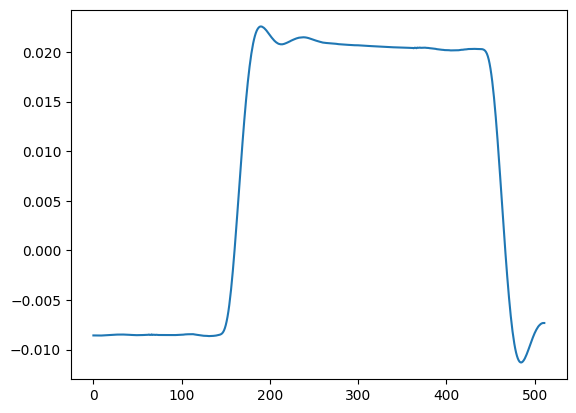

In [54]:
# sanity check
shape_rawraw = np.shape(rawraw)
seepl = np.reshape(rawraw, (-1, shape_rawraw[1]))

whatishere =slice_average_offset(
                    seepl,
                    (idx_av_0, idx_av_1),
                    (idx_bg_0, idx_bg_1),
                )
seepl  = np.mean(seepl, axis=0)
plt.plot(seepl)

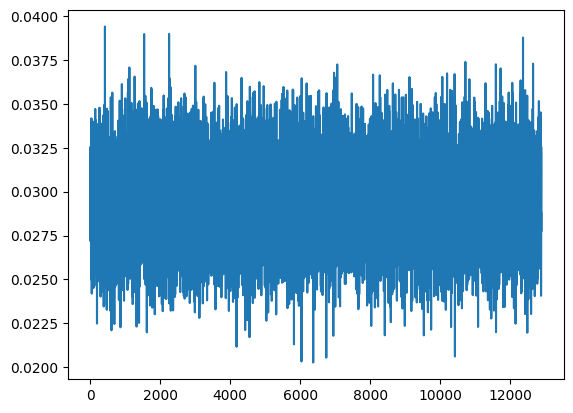

In [55]:
plt.plot(whatishere)

In [56]:

# # turn off laser and set diode current to zero
hw.laser.laser_off()
hw.laser.set_diode_current(0.00, save_memory=False)
# set pulse generator to zero
hw.pg.forceFinal()
hw.pg.constant(OutputState.ZERO())

# set mw amp and phase to zero
hw.vdi.set_amp_volt(0)
hw.vdi.set_phase_volt(0)

# dump remaining data & stop digitizer
# _ = hw.dig.stream()
hw.dig.stop_card()


# # Laser hardware reset
# try:
#     hw.laser.laser_off()  # turn off laser
#     hw.laser.set_diode_current(0.00, save_memory=False)
#     hw.laser.reset_alarm()
#     hw.laser.close()
#     hw.laser.open()
# except Exception as e:
#     logger.warning(f"Laser hardware reset failed: {e}")

# # Pulse generator reset
# try:
#     hw.pg.forceFinal()
#     hw.pg.reset()
#     # hw.pg.reboot()
# except Exception as e:
#     logger.warning(f"Pulse generator reset failed: {e}")

# # VDI system reset
# try:
#     hw.vdi.reset()
# except Exception as e:
#     logger.warning(f"VDI system reset failed: {e}")

# # Digitizer reset
# try:
#     hw.dig.stop_card()
#     hw.dig.reset()
# except Exception as e:
#     logger.warning(f"Digitizer reset failed: {e}")

2025-07-24 21:37:21 INFO laser MainThread: Laser emission is OFF
2025-07-24 21:37:21 INFO laser MainThread: Laser diode current set to '0.00%'
2025-07-24 21:37:22 INFO mwsource MainThread: Setting amplitude voltage to 0 V...
2025-07-24 21:37:22 INFO mwsource MainThread: Amplitude voltage set successfully.
2025-07-24 21:37:22 INFO mwsource MainThread: Setting phase voltage to 0 V...
2025-07-24 21:37:22 INFO mwsource MainThread: Phase voltage set successfully.


Card stopped


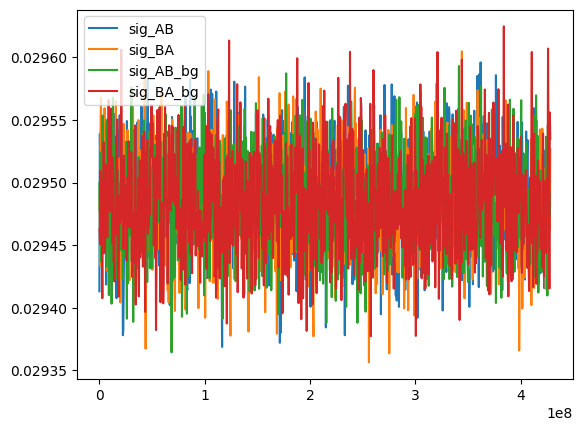

In [57]:
# import matplotlib.pyplot as plt
tau_AB = dataset["tau_AB"]
tau_BA = dataset["tau_BA"]
sig_AB = dataset["sig_AB"]
sig_AB_bg = dataset["sig_AB_bg"]
sig_BA = dataset["sig_BA"]
sig_BA_bg = dataset["sig_BA_bg"]
plt.plot(tau_AB, dataset["sig_AB"], label="sig_AB")
plt.plot(tau_BA, dataset["sig_BA"], label="sig_BA")
plt.plot(tau_AB, dataset["sig_AB_bg"], label="sig_AB_bg")
plt.plot(tau_BA, dataset["sig_BA_bg"], label="sig_BA_bg")
plt.legend()
plt.show()


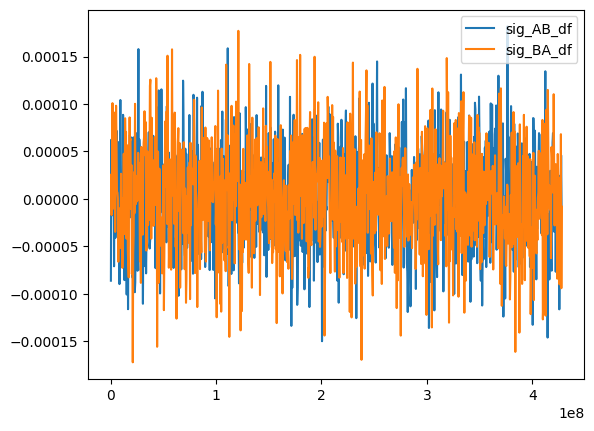

In [58]:
plt.plot(tau_AB, dataset["sig_AB"]-dataset["sig_AB_bg"], label="sig_AB_df")
plt.plot(tau_BA, dataset["sig_BA"]-dataset["sig_BA_bg"], label="sig_BA_df")
plt.legend()
plt.show()

In [59]:
# --- Define a helper function for FFT calculation ---
def calculate_fft(signal_avg, tau_array):
    N = len(signal_avg)
    try:
        T = tau_array[1] - tau_array[0]  # Sample spacing
    except IndexError:
        print("Warning: tau_array might not have enough points to determine sample spacing. Assuming T=1.")
        T = 1.0  # Default to 1 if not enough points

    # Remove DC component (mean) before FFT
    yf = np.fft.fft(signal_avg - np.mean(signal_avg))
    xf = np.fft.fftfreq(N, T)[:N//2] * 1e9

    # Amplitude normalization
    amplitude = 2.0/N * np.abs(yf[0:N//2])
    return xf, amplitude

# Calculate FFT for both signals
xf_AB, amp_AB = calculate_fft(sig_AB, dataset["tau_AB"])
xf_BA, amp_BA = calculate_fft(sig_BA, dataset["tau_BA"])
xf_AB, amp_AB_bg = calculate_fft(sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_bg = calculate_fft(sig_BA_bg, dataset["tau_BA"])
xf_AB, amp_AB_df = calculate_fft(sig_AB-sig_AB_bg, dataset["tau_AB"])
xf_BA, amp_BA_df = calculate_fft(sig_BA-sig_BA_bg, dataset["tau_BA"])


# --- Plotting with Plotly ---
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create subplots for time domain and frequency domain
fig = make_subplots(rows=1, cols=1,
                    subplot_titles=('Averaged Signals (Time Domain)', 'FFT of Averaged Signals (Frequency Domain)'))



# Add frequency domain plots
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB, mode='lines', name='FFT of sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA, mode='lines', name='FFT of sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB_bg, mode='lines', name='FFT of bg sig_AB'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA_bg, mode='lines', name='FFT of bg sig_BA'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_AB, y=amp_AB_df, mode='lines', name='FFT of sig_AB_df'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=xf_BA, y=amp_BA_df, mode='lines', name='FFT of sig_BA_df'),
              row=1, col=1)


# Update layout for frequency domain plot
fig.update_xaxes(title_text='Frequency (Hz)', row=1, col=1) # Changed to MHz
fig.update_yaxes(title_text='Amplitude', row=1, col=1)

# Update overall layout
fig.update_layout(width=800, showlegend=True, hovermode="x unified")
fig.show()